In [55]:
%load_ext autoreload
%autoreload 2

import control as ct
import numpy as np

# define plant
dt = 1
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
# C = np.eye(2)
# D = np.zeros((2, 1))
# plant = ct.StateSpace(A, B, C, D, dt=dt)

plant_update = lambda t, x, u, params: A @ x + B @ u
plant_output = lambda t, x, u, params: x

plant = ct.NonlinearIOSystem(
    updfcn=plant_update,
    outfcn=plant_output,
    dt=dt,
    inputs=[f'u{i}' for i in range(B.shape[1])],
    outputs=[f'x{i}' for i in range(A.shape[0])],
    states=[f'x{i}' for i in range(A.shape[0])],
    name='P'
)

t, y = ct.input_output_response(plant, U=1, T=np.arange(0, 10, dt))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


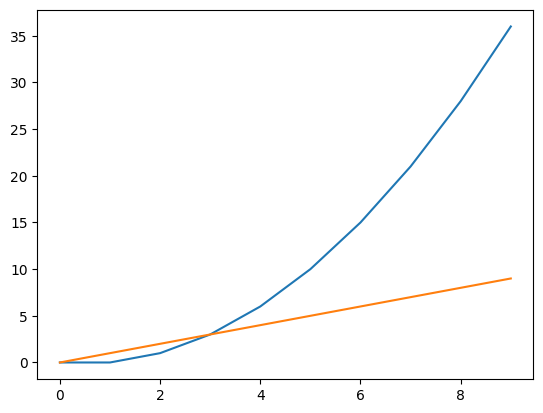

In [56]:
import matplotlib.pyplot as plt
plt.plot(t, y.T)

In [57]:
from ctrl.mpc.mpc import *

state_eq = lambda x, u : A @ x + B @ u
loss = lambda x, u : x.T @ x  + u ** 2
constraints = Constraints()
# constraints = Constraints(x_end={0: [0, 0]})
# constraints = Constraints(u_max=0.5, x_end={1: [2, 2]})
ss = lambda t, x, u, params: float(SingleShootingMethod(u, 2, 1, 10, dt, state_eq, loss, constraints)[0])

In [58]:
ss(None, None, [0, 1], None)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       46

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9500000e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

-1.2439272679814208

In [59]:
# Define the MPC controller as a NonlinearIOSystem (discrete-time)
mpc_ctrl = ct.NonlinearIOSystem(
    updfcn=None,
    outfcn=ss,
    dt=dt,
    inputs=['x0', 'x1'],
    outputs=['u0'],
    name='C'
)

In [60]:
# Create an interconnected system that captures the intermediate control signal
interconnected_sys = ct.interconnect(
    [plant, mpc_ctrl],
    connections=[['P.u0', 'C.u0'], ['C.x0', 'P.x0'], ['C.x1', 'P.x1']],
    inplist=['P.u0'],
    outlist=['P.x0', 'P.x1', 'C.u0']
)

# Simulate the system to get intermediate control signals
t, y = ct.input_output_response(interconnected_sys, X0=[5, 5], T=np.arange(0, 20, dt))


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       46

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

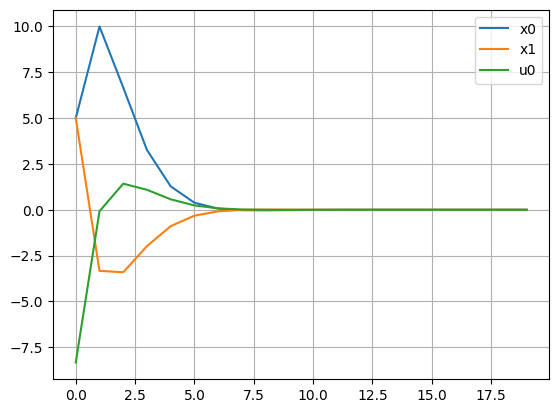

In [61]:
plt.plot(t, y.T)
plt.grid()
plt.legend(['x0', 'x1', 'u0'])

In [71]:
# multiple shooting method
ms = lambda t, x, u, params: float(MultipleShootingMethod(u, 2, 1, 2, dt, state_eq, loss, constraints)[0][0])

mpc_ctrl_ms = ct.NonlinearIOSystem(
    updfcn=None,
    outfcn=ss,
    dt=dt,
    inputs=['x0', 'x1'],
    outputs=['u0'],
    name='C'
)

ms(None, None, [0, 1], None)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

-0.5

In [72]:
interconnected_sys2 = ct.interconnect(
    [plant, mpc_ctrl_ms],
    connections=[['P.u0', 'C.u0'], ['C.x0', 'P.x0'], ['C.x1', 'P.x1']],
    inplist=['P.u0'],
    outlist=['P.x0', 'P.x1', 'C.u0']
)

# Simulate the system to get intermediate control signals
t, y = ct.input_output_response(interconnected_sys2, X0=[5, 5], T=np.arange(0, 20, dt))

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       46

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

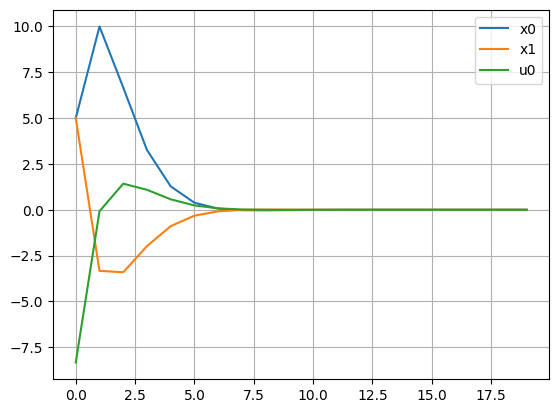

In [73]:
plt.plot(t, y.T)
plt.grid()
plt.legend(['x0', 'x1', 'u0'])